## Import Packages

In [1]:
from lib.gamearg import *
from IPython.display import display, Image

## WM move

In [2]:
%%file files/wm.lp

move("l", "e").
move("k", "l").
move("m", "n").
move("l", "m").
move("n", "m").
move("a", "b").
move("d", "f").
move("e", "h").
move("e", "m").
move("e", "d").
move("a", "c").
move("d", "g").
move("c", "d").
move("c", "e").
move("g", "d").
move("d", "e").
move("m", "e").
move("h", "i").
move("i", "j").
move("a", "o").
move("d", "h").

Overwriting files/wm.lp


In [3]:
input_file = "files/wm.lp"

## Show Plain Graph

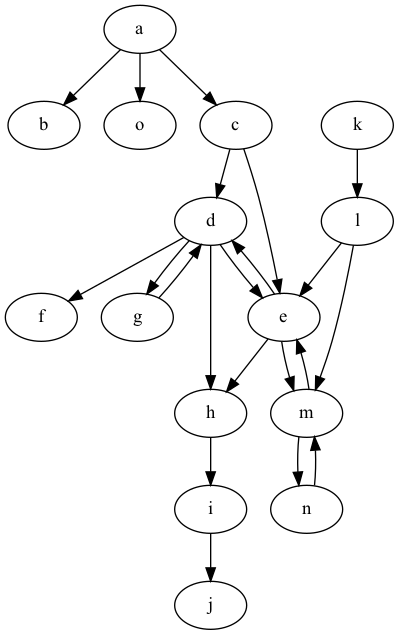

In [4]:
show_plain(input_file)

## Well-Founded Semantics

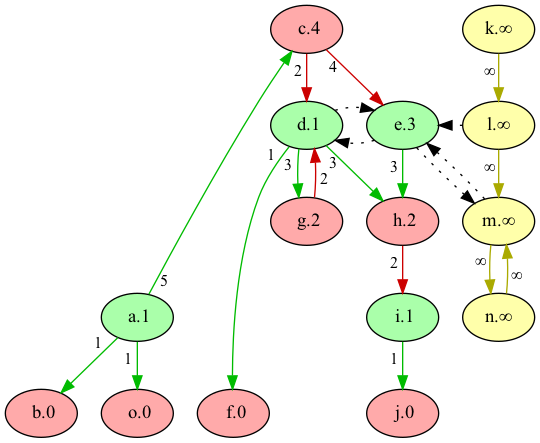

In [5]:
show_wfs(input_file)

## Stable Models

In [6]:
show_stb(input_file)